# CMSC320 Final Tutorial (Fall 2020)

## Analyzing the relationship between home matches and match wins in the English Premier League (Soccer)

### GROUP -> We Attac We Protec

##### Vikam Sehgal          Ashray Wadhwa          Naman Dua

### Introduction

With the English Premier League in full swing, discussion about the home game advantage happens to be a hot topic yet again. And with the beginning of the Covid-19 season, our group has had a little extra time to think. As a result, we are out to answer the question that is on everyone's mind - is there actually a strong relation between home games played by the teams, to the wins the same team ends up securing in a single season. 
 
Of course, there is a reason we seek to find the answer for ourselves and more importantly, for you. While a lot of the soccer fans might be interested in the answer for helping themselves in getting a boost of confidence when it comes to betting on matches and earning better profits, this answer would also ideally help in further development of soccer analysis. For instance, what we learn might be helpful in contributing to data analysis for comparing player and team quality across soccer history. 

So why wait, let's dive right in!


### Getting Started

Following is the research paper we used for building the base for our approach towards finding out the home game advantage. Please be sure to check it out in order to gain a deeper understanding of any formula we used for data analysis. 

Link for research paper on calculating home advantage: https://www.researchgate.net/publication/261402166_Calculating_the_Home_Advantage_in_Soccer_Leagues#:~:text=Home%2Dadvantage%20describes%20the%20benefit,%2C%202014)%20.%20...

Link where you can find all the data we used for our analysis (for seasons -> 2014-2019): 
https://datahub.io/sports-data/english-premier-league

Please note that we would not be taking the data for the premier league season 2019-2020 into account because of the Covid-19 pandemic and how it affected, the stadium attendance, matches played, and the sport in general. 


Importing the following python libraries is important for carrying out our data analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

In [2]:
data_set_18_19 = pd.read_csv('18_19_data.csv')
data_set_18_19.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


### Loading Data, Transforming, and Tidying
We will now transform, load, and tidy our data so as to be able to run desired operations on it.
Our dataset unfortunately does not provide us with an end of season table.
With the given information we can construct our own end of season table. 
We use information regarding the matches - what team was the home team, what team was the away team, did the home team win or did the away team win. These are all the questions we need answered to be able to construct our table.

### Steps:
We begin by creating a list of all the teams that are mentioned in the dataset. We then iterate over all the matches held in the season and add both the home team and the away team to the "teams" list. Since each team has had multiple matches the list will contain duplicates. We can simply transform the list to a set and then back to a list to be able to store it in our end of season table dataframe.

We then create a dictionary that stores the team name as the key and a match stat list as their value, with each index corresponding to either a win, loss, draw, home win, home goals scored, home goals conceded.

Lastly, we loop over this dictionary and add the stats to our data set.
To add points the english premier league follows a simple principle. For every match won the winning team gets 3 points, every match lost gives the team 0 points, every match that ends as a draw gives both the teams 1 point.

In [3]:
# group by teams to create columns of team, wins, loss, home wins, home goals scored, home goals conceded
def data_to_df(data_set):
    teams = []
    team_stat = {}
    for i in data_set.iterrows():
        teams.append(i[1].HomeTeam)
        teams.append(i[1].AwayTeam)
    #remove duplicates from teams
    teams = set(teams)
    for i in teams:
        team_stat[i] = [0,0,0,0,0,0,0]
    for i in data_set.iterrows():
        team_stat[i[1].HomeTeam][0]+=1
        team_stat[i[1].AwayTeam][0]+=1
        team_stat[i[1].HomeTeam][5]+=i[1].FTHG
        team_stat[i[1].HomeTeam][6]+=i[1].FTAG
        if i[1].FTHG > i[1].FTAG:
            team_stat[i[1].HomeTeam][1]+=1
            team_stat[i[1].HomeTeam][4]+=1
            team_stat[i[1].AwayTeam][2]+=1
        elif i[1].FTHG < i[1].FTAG:
            team_stat[i[1].AwayTeam][1]+=1
            team_stat[i[1].HomeTeam][2]+=1
        else:
            team_stat[i[1].HomeTeam][3]+=1
            team_stat[i[1].AwayTeam][3]+=1
    # print(team_stat)
    mp, wins, loss, draw, hw, hgs, hgc = [],[],[],[],[], [], []
    for v in team_stat:
        mp.append(team_stat[v][0])
        wins.append(team_stat[v][1])
        loss.append(team_stat[v][2])
        draw.append(team_stat[v][3])
        hw.append(team_stat[v][4])
        hgs.append(team_stat[v][5])
        hgc.append(team_stat[v][6])
    points = []
    #calculate points
    for i in range(0,len(mp)):
        points.append(wins[i]*3 + draw[i])
    epl_table = pd.DataFrame(data={'team': list(teams), 'matches_played': mp,
                                   'wins':wins, 'loss':loss,
                                   'draw':draw, 'home_win': hw,
                                  'points': points, 'home_goals': hgs,
                                  'home_goals_conceded': hgc})
    return epl_table.sort_values(by=['points'], ascending=False)
epl_table = data_to_df(data_set_18_19)
epl_points = epl_table.sort_values(by=['points'], ascending=False)
epl_home_games = epl_table.sort_values(by=['home_win'], ascending=False)

In [17]:
# We then print the End of season table sorted by points and by then by number of home games won

# End of season table sorted by points
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
0,Man City,38,32,4,2,18,98,57,12
10,Liverpool,38,30,1,7,17,97,55,10
4,Arsenal,38,21,10,7,14,70,42,16
17,Chelsea,38,21,8,9,12,72,39,12
9,Tottenham,38,23,13,2,12,71,34,16
8,Man United,38,19,10,9,10,66,33,25
11,Wolves,38,16,13,9,10,57,28,21
5,Everton,38,15,14,9,10,54,30,21
1,West Ham,38,15,16,7,9,52,32,27
3,Newcastle,38,12,17,9,8,45,24,25


In [ ]:
# End of season table sorted by points 
epl_home_games

Now that we have ensured that the data has been loaded and tidied up appropriately, we add certain new calculated entries to the table in the form of total win percentage and a home win percentage. 

### Adding Some Important Metrics

Now that we have the table for a single season, we will add some new columns to the table important in getting one step closer to our answer.

We will calculate the following:
 1. Home Win % = home_win / home matches_played (19)
 2. Total Win % = wins / matches_played

In [5]:
epl_points['home_win%'] = epl_points['home_win']/19
epl_points['total_win%'] = epl_points['wins']/epl_points['matches_played']
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
0,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105
10,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474
17,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632
9,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263
4,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632
8,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000
11,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053
5,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737
1,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737
7,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737


To get a clearer idea of the scale of advantage a home game gives, we add the 'home_advantage' feature.
Home advantage in the english premier league is calculated as follows:
 
 Home Advantage = (Home Goals Scored - Home Goals Conceded) / 19

source for calculation of home field advantage in soccer: https://www.pinnacle.com/en/betting-articles/Soccer/Home-Field-Advantage/FGU2ZXMPGZCTFHSE

In [6]:
epl_points['home_advantage'] = (epl_points['home_goals'] - epl_points['home_goals_conceded']) /19
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
0,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
10,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
17,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
9,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
4,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
8,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
11,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
5,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
1,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158
7,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526


Now that we have the season 18-19 table for analysis, we make use of more descriptive statistics in the form of graphs and charts in order to help us understand the behavior pertaining to teams and their home game performances over the years. 

### Plots for season 18-19

We now visualize the home advantage and the home_win% by plotting line charts.

Here the x axis represents the teams in the premier league that season, and y axis represents the home advantage and home_win%.


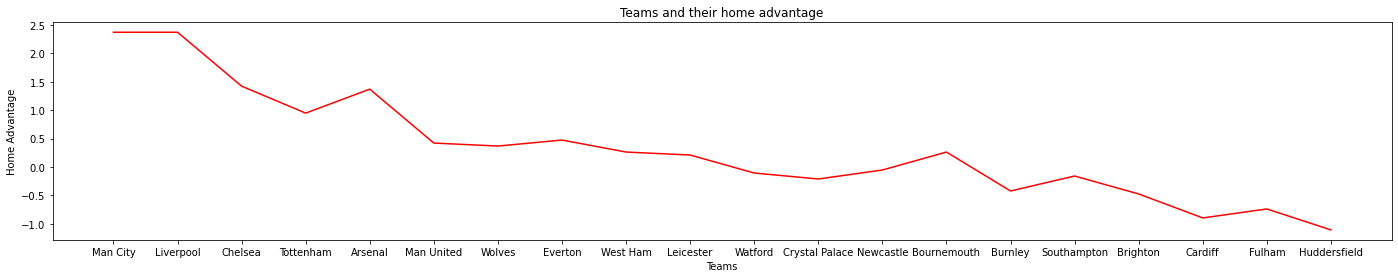

In [7]:
plt.figure(figsize=(24,4))
plt.plot(epl_points['team'], epl_points['home_advantage'], 'r-', label='win_adv')
plt.title('Teams and their home advantage')
plt.xlabel('Teams')
plt.ylabel('Home Advantage')
plt.show()

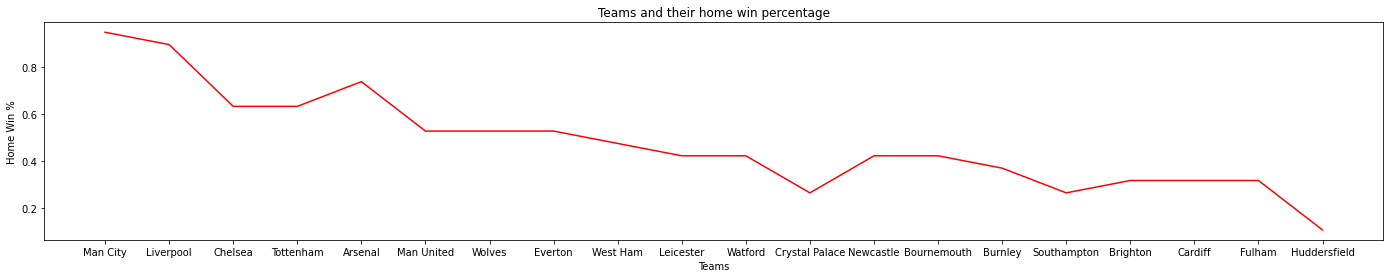

In [8]:
plt.figure(figsize=(24,4))
plt.plot(epl_points['team'], epl_points['home_win%'], 'r-', label='win_adv')
plt.title('Teams and their home win percentage')
plt.xlabel('Teams')
plt.ylabel('Home Win %')
plt.show()

### Observation:

We observe that both the charts appear to be similar in trend which is expected because home win percentage and home advantage go hand in hand. But we would ideally expect to see a more flatter chart to gauge if all teams have an evenly spread advantage if they play at home. 

While these charts might be appropriate for getting a very high-level view of whether home game and performance correlate, we cannot really extract a lot of information out of it.

This is why we will be looking at the data from 4 other seasons from the past and will be using more sophisticated techniques to eventually step closer to the completion of our analysis. 

In [9]:
# Load data from other 4 seasons: 14-15, 15-16, 16-17, 17-18
epl_table1415 = data_to_df(pd.read_csv('14_15_data.csv'))
epl_table1516 = data_to_df(pd.read_csv('15_16_data.csv'))
epl_table1617 = data_to_df(pd.read_csv('16_17_data.csv'))
epl_table1718 = data_to_df(pd.read_csv('17_18_data.csv'))
epl_table1819 = epl_points
lst = [epl_table1415, epl_table1516, epl_table1617, epl_table1718]
year = 0
epl_table1819['year'] = [2018]*20
for i in lst:
    i['home_win%'] = epl_points['home_win']/19
    i['total_win%'] = epl_points['wins']/epl_points['matches_played']
    i['home_advantage'] = (i['home_goals'] - i['home_goals_conceded']) /19
    i['year'] = [2014 + year]*20
    year += 1

### Display Scatter plot for each season by their win advantage

sort each table by points so we get a relation between the teams performance and their home advantage. The x axis even though only says the name is actually sorted based on their performance in the season. 
Left to right, is best to worst.



Left -> Right

Best -> Worst


ESTABLISH RELATION BETWEEN ALL THESE PLOTS AND CHECK IF WE SEE IF THE RELATION MAKES SENSE.

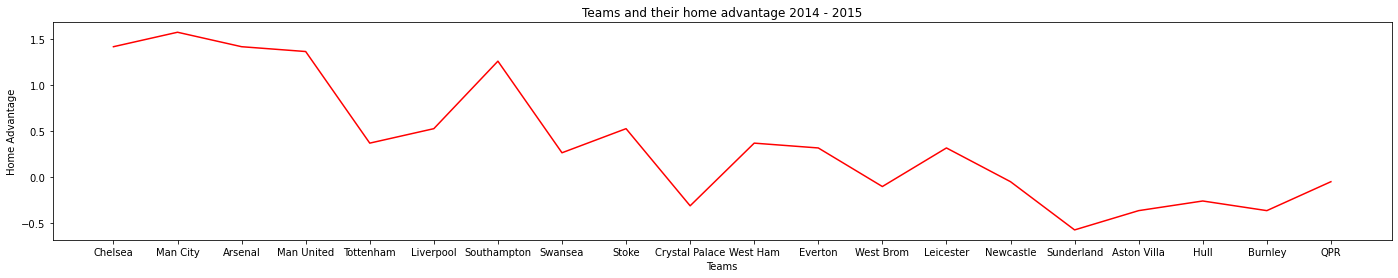

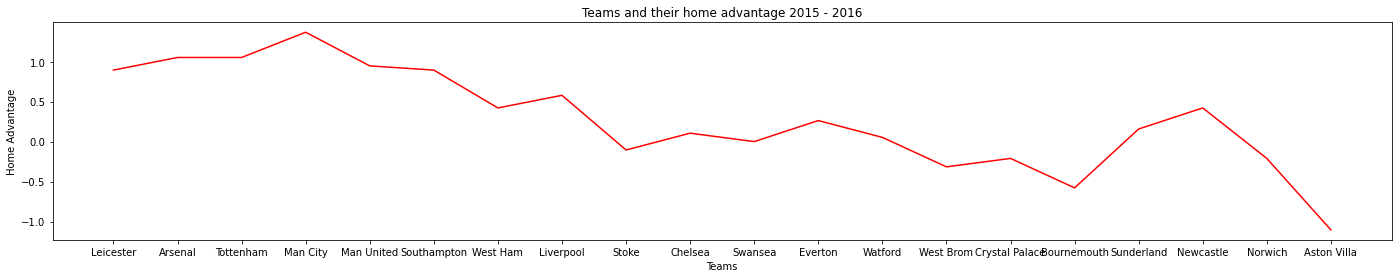

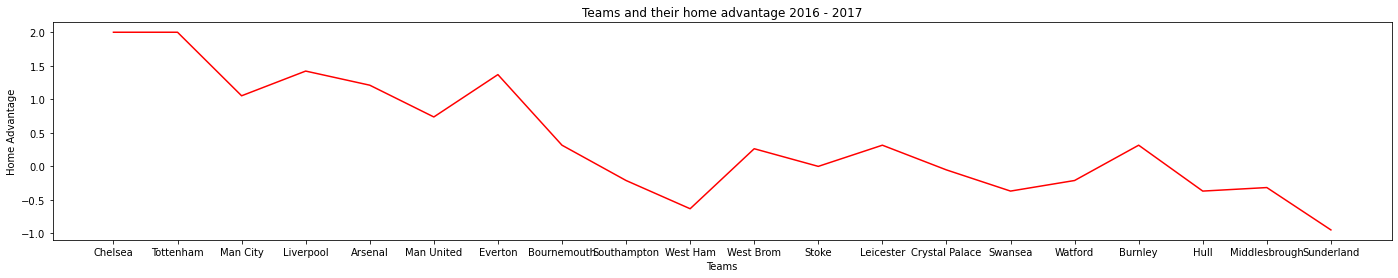

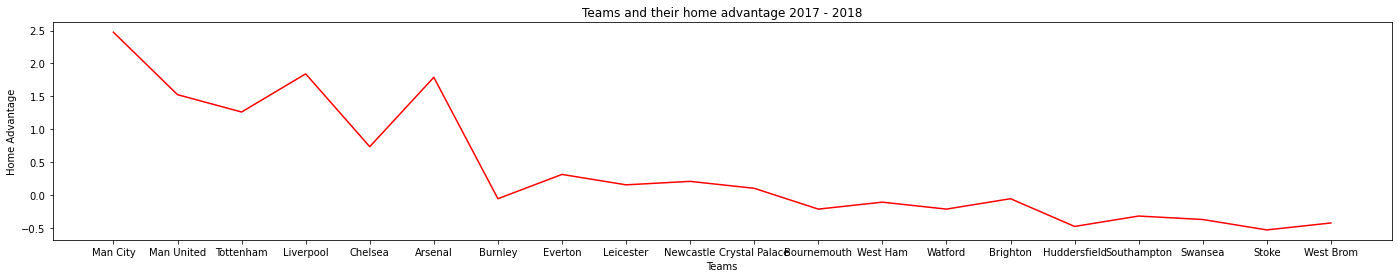

In [10]:
lst = [epl_table1415, epl_table1516, epl_table1617, epl_table1718]
lst2 = ['2014 - 2015','2015 - 2016','2016 - 2017','2017 - 2018']
for ind, val in enumerate(lst):
    val = val.sort_values(by=['points'], ascending=False)
    plt.figure(figsize=(24,4))
    plt.plot(val['team'], val['home_advantage'], 'r-', label='win_adv')
    plt.title('Teams and their home advantage ' + lst2[ind])
    plt.xlabel('Teams')
    plt.ylabel('Home Advantage')
    plt.show()

### Observation : 
As we can see from the graphs plotted above for the 14/15 season to 17/18 seasons. We get a similar graph in all the cases, which helps us maintain the hypothesis that the greater the home advantage the better the teams performed in the season. We have shown seasonal performance through the graphs itself on the X-Axis, the team names are arranged in each graph according to seasonal finishes, where the first team on the left is the team that finished first, whereas on the right the last team is the one that finished last in the season. We can easily infer from the data we can see in the graphs that home advantage is highly correlated to the seasonal performance a team has. In simple terms, we can say that a team which has a high home advantage, has a great season. There is one outlier in the following graphs which is Newcastle United in the 15/16 season who had a high home advantage but their performance that season was horrible. Other than this outlier, our hypothesis holds true.

We now combine the tables from all seasons we have taken into consideration, and with the appropriate variables for making violin plots and understanding the behavior and relationship between home games and match performances better. 

In [11]:
combined_table = pd.concat([epl_table1415, epl_table1516, epl_table1617, epl_table1718, epl_table1819], axis=0)

We take increments of 1 year and utilize the performance data from 5 seasons  across all teams. 
The x-axis represents the years and the y-axis depicts the spread of home advantage across all teams for each season seen on the x-axis. 

<AxesSubplot:xlabel='year', ylabel='home_advantage'>

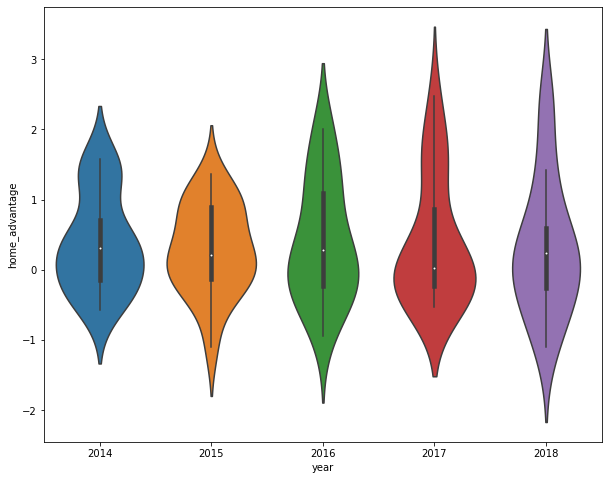

In [18]:
increments = ['2014', '2015', '2016', '2017', '2018']
season_table = combined_table.loc[combined_table['year'].isin(increments)]
season_table
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.violinplot(ax=ax, x=season_table['year'], y=season_table['home_advantage'])

### Observation:

The violin plot more clearly shows the distribution of values for each year by displaying the density of each by the width of the violins at each of those points. 

It can be observed that for all the seasons taken into consideration, we see an almost identical distribution of density for home advantages across all teams. The highest density of home advantages is usually around 0 for almost all seasons and peaking a little unusually around 1 for the season of 2015-2016. 

All the violins can be seen as representing unimodal data with the seasons not really impacting the shape of the distribution. 

We can learn that this bottom-heavy trend, dense around 0, in fact takes away from what we are hoping for the behavior of relationship between home games and team performance to be. This is because the violin plot depicts the fact that most teams playing in the league have the home advantages around the value of 0 indicating that the home game advantage might actually exclusively apply to only some of the teams. 

In order to analyse the data further, we make more pictorial depictions related to our current information. 

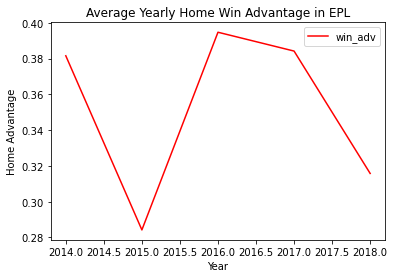

<AxesSubplot:title={'center':'Average team home advantage 2014-2018'}, xlabel='team'>

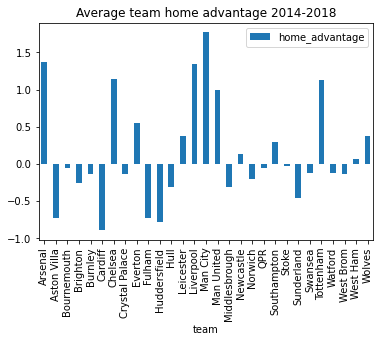

In [13]:
epl_avg = combined_table.groupby(['year'], as_index=False)['home_advantage'].mean()
team_avg = combined_table.groupby(['team'], as_index=False)['home_advantage'].mean()
plt.plot(epl_avg['year'], epl_avg['home_advantage'], 'r-', label='win_adv')
plt.xlabel('Year')
plt.ylabel('Home Advantage')
plt.title('Average Yearly Home Win Advantage in EPL')
plt.legend()
plt.show()
team_avg.plot(x='team', y='home_advantage', kind='bar', title='Average team home advantage 2014-2018')

### Analyzing the plots

### Relation between Home Advantage and Attendance

Our first analysis that we make is whether home game advantage is related to audience attendance, whether having a big home crowd supporting the teams is known to be very intimidating for the away team. Not only, do these crowds chant their slogans a lot, but also can be very crucial in setting morale for the home team.
To perform this procedure, we have used BeautifulSoup4 to scrape the website data from the following website for each season- Premier League 2018/2019 » Attendance » Home matches . We have used the data for the other previous seasons, 14/15 onwards. We have broken the data down to 3 columns in a dictionary with the team-name as the key and the first value being the total attendance throughout the season for a team’s home matches, and the third value being the audience average throughout the season for home matches per team.









In [14]:
def get_attendence(url):
    page = requests.get(url)
    # print(page.status_code)
    soup = BeautifulSoup(page.content, 'html.parser')
    tb = soup.find('table', class_='standard_tabelle')
    team_lst = {}
    team_capacity = []
    for ana in tb.findAll('a'):
        if ana.find('img'):
            continue
        else:
            team_lst[ana.text] = []

    for ana in tb.findAll('td',{'align':'right'}):
        txt = ana.text.replace('.', '')
        team_capacity.append(txt)

    i = 0
    for k in team_lst:
        team_lst[k] = [team_capacity[i], team_capacity[i+1]]
        i+=2
    # clean up name of manchester united and manchest city for later use
    team_lst['Man City'] = team_lst['Manchester City']
    del team_lst['Manchester City']
    team_lst['Man United'] = team_lst['Manchester United']
    del team_lst['Manchester United']
    return team_lst
attendence18_19 = get_attendence('https://www.worldfootball.net/attendance/eng-premier-league-2018-2019/1/')
attendence17_18 = get_attendence('https://www.worldfootball.net/attendance/eng-premier-league-2017-2018/1/')
attendence16_17 = get_attendence('https://www.worldfootball.net/attendance/eng-premier-league-2016-2017/1/')
attendence15_16 = get_attendence('https://www.worldfootball.net/attendance/eng-premier-league-2015-2016/1/')
attendence14_15 = get_attendence('https://www.worldfootball.net/attendance/eng-premier-league-2014-2015/1/')

attendence18_19

{'Arsenal FC': ['1138072', '59899'],
 'West Ham United': ['1108375', '58336'],
 'Tottenham Hotspur': ['1030111', '54216'],
 'Liverpool FC': ['1006668', '52983'],
 'Newcastle United': ['971297', '51121'],
 'Chelsea FC': ['768297', '40437'],
 'Everton FC': ['736815', '38780'],
 'Leicester City': ['605161', '31851'],
 'Cardiff City': ['596844', '31413'],
 'Wolverhampton Wanderers': ['589572', '31030'],
 'Brighton & Hove Albion': ['578085', '30426'],
 'Southampton FC': ['572640', '30139'],
 'Crystal Palace': ['483644', '25455'],
 'Fulham FC': ['463051', '24371'],
 'Huddersfield Town': ['440822', '23201'],
 'Burnley FC': ['390148', '20534'],
 'Watford FC': ['380297', '20016'],
 'AFC Bournemouth': ['200107', '10532'],
 'Man City': ['1028477', '54130'],
 'Man United': ['1415471', '74498']}

In [15]:
def split_attend(table, attendence):
    total_attendence = []
    average_game_attendence = []
    for i in table.team:
        if i == 'QPR':
            val = [value for key, value in attendence.items() if 'Queens Park' in key]
        elif i == 'Wolves':
            val = [value for key, value in attendence.items() if 'Wolverhampton Wanderers' in key]
        else:
            val = [value for key, value in attendence.items() if i in key]
        total_attendence.append(int(val[0][0]))
        average_game_attendence.append(int(val[0][1]))
    return [total_attendence,average_game_attendence]
lst = [epl_table1415, epl_table1516, epl_table1617, epl_table1718, epl_table1819]
lst2 = [attendence14_15, attendence15_16, attendence16_17, attendence17_18, attendence18_19]
for ind,val in enumerate(lst):
    curr_split = split_attend(val, lst2[ind])
    val['total_attendence'] = curr_split[0]
    val['avg_game_attd'] = curr_split[1]


From this observation, we can start investigating why certain teams seem to have more distinct home advantages compared to others. Intuitively, we should be able to measure what affects home advantage more easily than what affects a teams overall performance. This is because while teams cycle through players of varying quality each year, the difference in conditions between home games and away games remains relatively constant except for a few factors such as player fitness, player quality, and current form.


#### In Our Graphs we have plotted the X-Axis as Team Names and the Y-Axis as Crowd Attendance (In Blue) and Home Advantage (In Red)

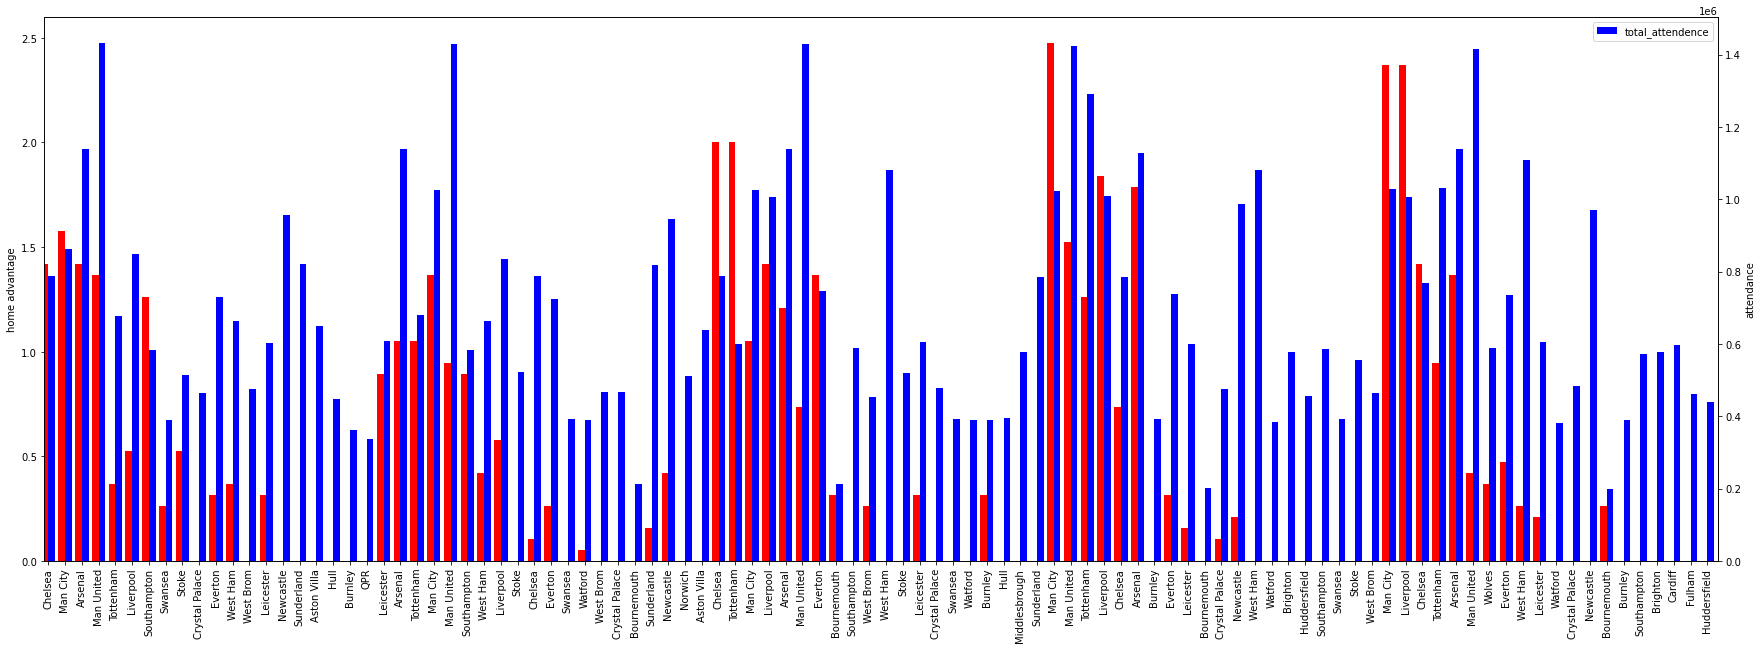

In [16]:
combined_table = pd.concat([epl_table1415, epl_table1516, epl_table1617, epl_table1718, epl_table1819], axis=0)
# we only look at the teams with positive home advantage so as to not skew our bar plots.
home_advNA = []
for i in combined_table.home_advantage:
    if i<0:
        home_advNA.append(np.nan)
    else:
        home_advNA.append(i)
combined_table['home_advNA'] = home_advNA

fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

combined_table.home_advNA.plot(kind='bar', color='red', ax=ax, width=width, position=1, figsize=(30,10))
combined_table.total_attendence.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, figsize=(30,10))
ax2.set_ylabel('attendance')
ax.set_ylabel('home advantage')
plt.xticks(np.arange(len(combined_table.team)), combined_table.team)
plt.legend()
plt.show()

### Observation:

Looking at the difference between teams such as Manchester United and Bournemouth we can easily tell the differences home advantages creates, while the former had a good season finish being 6th on the table with a great number of home wins in comparison to Bournemouth, who finished not only 14th on the table just surviving relegation for the season. But, also with the lowest attendance crowds throughout the season, while Manchester United was a team with the highest overall attendance in the season.Being one of the oldest clubs in English Football, Manchester United as a team has gained great fan loyalty, and this we believe really affects team morale and team performances and really ups the home advantage scale. We go on to further our research by making bar graphs to find a correlation between home advantage and attendance. Our code helps us figure out whether our hypothesis is true. We were unable to take the latest dataset of the 19/20 season into account as there was no in-person attendance in any of the Premier League matches due to Covid-19. And, this anomaly would ruin the research on finding whether home advantage and crowd attendance are correlated, we have chosen to ignore this in our research.